In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/raw/Obesity prediction.csv')

In [2]:
obesity_level = df.groupby("Obesity")["Weight"].median().sort_values().reset_index().reset_index(drop = False).rename(columns = {"index":"Obesity_level"})
df = df.merge(obesity_level[["Obesity_level", "Obesity"]], on = "Obesity", how = "left")
df[["Obesity", "Obesity_level"]].drop_duplicates().to_dict("records")
df["Obesity_binary"] = (df["Obesity_level"] > 3).astype(int)

Remember to drop columns that can leak into training data. We are not dropping the main target variable yet. 

In [3]:
df.drop(columns = ["Obesity", "Obesity_level"], inplace = True)

## Setting up validation framework

In [4]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [5]:
len(df_train), len(df_val), len(df_test)

(1266, 422, 423)

In [6]:
# now we take the target variable out of the training data
y_train = df_train["Obesity_binary"].values
y_val = df_val["Obesity_binary"].values
y_test = df_test["Obesity_binary"].values
# and drop it from the training data
del df_train["Obesity_binary"]
del df_val["Obesity_binary"]
del df_test["Obesity_binary"]

## Model 1. Logistic Regression

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

def train_LR(df_train, y_train, C=1.0):

    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict_LR(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

### Parameter tuning

The parameter we want to tune is C. We will use cross-validation to find the best value of C.

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
import numpy as np
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.Obesity_binary.values
        y_val = df_val.Obesity_binary.values

        dv, model = train_LR(df_train, y_train, C=C)
        y_pred = predict_LR(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.973 +- 0.006
C=0.01 0.991 +- 0.003
C=0.1 1.000 +- 0.000
C=0.5 1.000 +- 0.000
C=1 1.000 +- 0.000
C=5 1.000 +- 0.000
C=10 1.000 +- 0.000


Based on this we choose C = 0.1

In [9]:
dv, model = train_LR(df_full_train, df_full_train.Obesity_binary.values, C=0.1)
y_pred = predict_LR(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.9862671941023106

We have good score on the test dataset. Even though auc is perfect on training dataset, it is not bad on test dataset. Implying model is not overfitting.

## Model 2. Decision Tree Classifier

In [22]:
from sklearn.tree import DecisionTreeClassifier

def train_DT(df_train, y_train, max_depth=None, min_samples_leaf = 1):

    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
    model.fit(X_train, y_train)
    
    return dv, model

def predict_DT(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

Training a single decision tree

In [25]:
dv, model = train_DT(df_train, y_train)
y_pred = predict_DT(df_val, dv, model)
print("AUC Score on training dataset", roc_auc_score(y_val, y_pred))

y_test_pred = predict_DT(df_test, dv, model)
print("AUC Score on test dataset", roc_auc_score(y_test, y_test_pred))

AUC Score on training dataset 1.0
AUC Score on test dataset 0.5


Decision trees can overfit. t easily. So we need to tune the parameters to prevent overfitting. 

### Parameter tuning

We will use the max_depth and min_samples_leaf parameters. 

In [30]:
scores = []

for depth in [2, 4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dv, model = train_DT(df_train, y_train, max_depth=depth, min_samples_leaf=s)
        y_test_pred = predict_DT(df_test, dv, model)

        auc = roc_auc_score(y_test, y_test_pred)
        
        scores.append((depth, s, auc))

columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc               
max_depth           2    4    5    6
min_samples_leaf                    
1                 0.5  0.5  0.5  0.5
5                 0.5  0.5  0.5  0.5
10                0.5  0.5  0.5  0.5
15                0.5  0.5  0.5  0.5
20                0.5  0.5  0.5  0.5
100               0.5  0.5  0.5  0.5
200               0.5  0.5  0.5  0.5
500               0.5  0.5  0.5  0.5

Model seems to overfit

### Model 3. Random Forest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

def train_RF(df_train, y_train, n_estimators = 25):

    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = RandomForestClassifier(n_estimators=n, random_state=1)
    model.fit(X_train, y_train)
    
    return dv, model

def predict_RF(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [41]:
scores = []

for n in range(10, 201, 10):

    dv, model = train_RF(df_train, y_train, n_estimators=n)

    y_pred = predict_RF(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

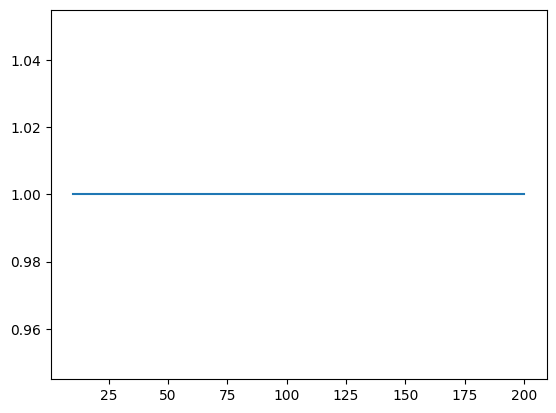

In [42]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)

In [43]:
y_test_pred = predict_RF(df_test, dv, model)
auc = roc_auc_score(y_test, y_test_pred)
auc

0.9992807695765532

Model does not seem to overfit